# Аналитика в Яндекс.Афише

## План работ
<a id=plan></a>
[**Шаг 1. Загрузить данные и подготовить их к анализу**](#step1)

- [x] Загрузить данные из таблиц, провести первичный анализ 
- [x] Оптимизировать данные для анализа (поиск дублей, анализ пропусков, проверка названий столбцов и т.п.)
- [x] Проверка/корректировка типо данных

[**Шаг 2. Построить отчёты и посчитать метрики**](#step2)

Продукт

- [x] Рассчитано, сколько людей (уникальных!) пользуются в день, неделю, месяц (DAU, WAU, MAU)
- [x] Рассчитано, сколько сессий в день 
- [x] Рассчитано, сколько обычно длится одна сессия
- [x] Рассчитано, как часто люди возвращаются (retention rate для каждой когорты)
- [x] Сформулированы выводы

Продажи

- [x] Рассчитано, когда люди начинают покупать. Среднее/медианное количество дней между первым визитом и покупкой. 
- [x] Рассчитано, сколько раз совершают покупку за день/месяц/год, построен график (временные ряды??).
- [x] Найден средний чек и продемонстрировано как он менялся по дням/месяцам/годам. Построен график.
- [x] Найден значение LTV для каждо из когорт.
- [x] Сформулированы выводы

Маркетинг

- [x] Посчитано сколько денег потратили. Всего / на каждый источник / по времени. Построен график. 
- [x] Определено сколько стоило привлечение одного покупателя из каждого источника. (CAC)
- [x] Рассчитано, на сколько окупились расходы? (ROI)
- [x] Сформулированы выводы

[**Шаг 3. Написать вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?**](#step3)

Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

<a id=step1></a>
# Шаг 1. Загрузите данные и подготовьте их к анализу

In [41]:
# импорт необходимых библиотек и настройка jupiter
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats as st
import numpy as np 

# для отображения в jupiter всех колонок и столбцов df + сокращу количество цифр после запятой
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision',2)

In [42]:
costs = pd.read_csv('/datasets/costs.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
visits = pd.read_csv('/datasets/visits_log.csv')

In [43]:
display(costs.head())
display(costs.info())
display(costs.describe())
print('Количество дублей:', costs.duplicated().sum())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,source_id,costs
count,2542.00,2542.00
mean,4.86,129.48
std,3.18,156.30
min,1.00,0.54
25%,2.00,21.95
50%,4.00,77.30
75%,9.00,170.06
max,10.00,1788.28


Количество дублей: 0


Требуется преобразование типа данных для даты

In [44]:
costs['dt'] =  costs['dt'].astype('Datetime64')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [45]:
display(orders.head())
display(orders.info())
display(orders.describe())
print('Количество дублей:', orders.duplicated().sum())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Revenue,Uid
count,50415.00,5.04e+04
mean,5.00,9.10e+18
std,21.82,5.29e+18
min,0.00,3.14e+14
25%,1.22,4.53e+18
50%,2.50,9.10e+18
75%,4.89,1.37e+19
max,2633.28,1.84e+19


Количество дублей: 0


Необходимо поменять тип данный для даты, переименовать столбцы и детальнее посмотреть на нулеве значения дохода и максимальные, уж очень это похоже на выбросы.

In [46]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [47]:
orders.columns=['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = orders['buy_ts'].astype('Datetime64')

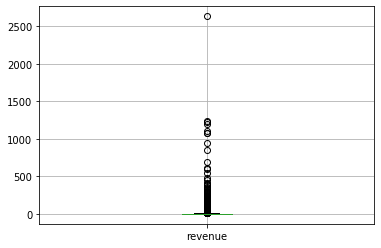

In [48]:
orders.boxplot(column='revenue')

In [49]:
orders.query('revenue==0').count()

buy_ts     51
revenue    51
uid        51
dtype: int64

Итого мы имеем достаточное количество клиентов, которые принесли сверх прибыль. Возможно в будущем от них нужно будет избавиться, но пока же уберем только заказы, которые не принесли нам прибыли. 

In [50]:
orders = orders.query('revenue != 0')

In [51]:
display(visits.head())
display(visits.info())
display(visits.describe())
print('Количество дублей:', visits.duplicated().sum())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Source Id,Uid
count,359400.00,3.59e+05
mean,3.75,9.20e+18
std,1.92,5.30e+18
min,1.00,1.19e+13
25%,3.00,4.61e+18
50%,4.00,9.23e+18
75%,5.00,1.37e+19
max,10.00,1.84e+19


Количество дублей: 0


Поменяем название колонок, приведем дату к нужному типу

In [52]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ss', 'uid']
visits[['end_ts','start_ss']]=visits[['end_ts','start_ss']].astype('Datetime64')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ss   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


## Вывод

Серьезных проблем не было, привел названия столбцов в корректный формат, поменял тип данных в столбцах с датами, убрал пару лишних записей. Данные подготовлены для дальнейших манипуляций и обработки.

[План работы](#plan)

<a id=step2></a>
# Шаг 2. Построить отчёты и посчитать метрики
## Продукт

In [53]:
# выделяем год/месяц/неделю/день посещения
visits['year'] = visits['start_ss'].dt.year
visits['month'] = visits['start_ss'].dt.month
visits['week'] = visits['start_ss'].dt.week
visits['day'] = visits['start_ss'].dt.date

In [54]:
DAU = int(visits.groupby('day')['uid'].nunique().mean())
WAU = int(visits.groupby(['year','week'])['uid'].nunique().mean())
MAU = int(visits.groupby(['year','month'])['uid'].nunique().mean())
print(' DAU =',DAU,'\n', 'WAU =',WAU ,'\n', 'MAU =',MAU,'\n','sticky factor =', round(DAU/WAU, 2))

 DAU = 907 
 WAU = 5716 
 MAU = 23228 
 sticky factor = 0.16


Посчитали среднее количество посещений

In [55]:
sessions_by_month = visits.groupby(['day']).agg({'uid':['count']}).mean()
print('Среднее количество сессий в день', int(sessions_by_month))

Среднее количество сессий в день 987


In [56]:
# посмотрим на длительность сессий
visits['session_duration'] = (visits['end_ts'] - visits['start_ss']).dt.seconds

In [57]:
visits['session_duration'].describe()

count    359400.00
mean        643.51
std        1016.33
min           0.00
25%         120.00
50%         300.00
75%         840.00
max       84480.00
Name: session_duration, dtype: float64

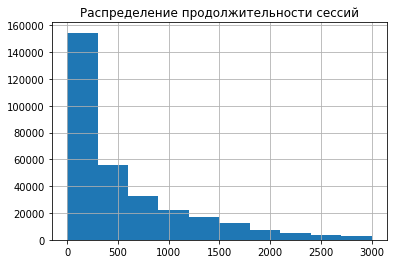

In [58]:
# уберем слишком выдающиеся значения
visits['session_duration'].hist(range=[1,3000])
plt.title('Распределение продолжительности сессий');

In [59]:
print('Самая часто встречающаяся продолжительность сессии -',visits['session_duration'].mode()[0])

Самая часто встречающаяся продолжительность сессии - 60


Определили среднее количество сессий в день и посмотрели на продолжительность сессий

Приступим к анализу retention, подготовим данные для когортного анализа

In [60]:
# добавим год/месяц первого визита , чтобы сформировать когорты
first_visits = visits.groupby('uid')['start_ss'].min()
first_visits.name='first_visit'
visits = visits.join(first_visits, on='uid')
visits['first_visit'] = visits['first_visit'].astype('datetime64[M]')

visits.head()

,device,end_ts,source_id,start_ss,uid,year,month,week,day,session_duration,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-01


In [61]:
# добавим год/месяц визита
visits['visit_month'] =  visits['start_ss'].astype('datetime64[M]')
visits['lifetime'] = ((visits['visit_month'] - visits['first_visit']) / np.timedelta64(1,'M')).round().astype('int')

In [62]:
# посчитаем сколько пользвателей было в каждой когорте в определенный lifetime
visit_cohorts = visits.groupby(['first_visit','lifetime'])['uid'].nunique().reset_index()
visit_cohorts.head()

,first_visit,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [63]:
# сохраним сколько пользователей было в 0ой lifetime в каждой когорте
initial_cohorts_users = visit_cohorts[visit_cohorts['lifetime'] == 0][['first_visit','uid']]
initial_cohorts_users.rename(columns={'uid':'initial_users'}, inplace=True)
initial_cohorts_users.head()

,first_visit,initial_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


In [64]:
visit_cohorts = visit_cohorts.merge(initial_cohorts_users, on='first_visit')

In [65]:
visit_cohorts['retention'] = (visit_cohorts['uid']/visit_cohorts['initial_users'])*100
visit_cohorts.pivot_table(index='first_visit', columns='lifetime', 
                          values='retention', aggfunc='mean',fill_value='')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit,,,,,,,,,,,,
2017-06-01,100.0,7.9,5.4,6.1,6.9,7.1,6.1,5.8,5.2,5.1,4.1,4.5
2017-07-01,100.0,5.6,5.1,5.6,5.8,4.8,4.5,4.6,3.9,2.9,2.7,
2017-08-01,100.0,7.7,6.3,6.3,5,4.4,3.6,3.9,2.8,2.6,,
2017-09-01,100.0,8.5,6.9,5.1,3.9,3.8,3.6,2.4,2.3,,,
2017-10-01,100.0,7.9,5.2,3.9,3.4,3.2,2.1,2,,,,
2017-11-01,100.0,7.8,4.4,3.9,3.4,2.3,2.2,,,,,
2017-12-01,100.0,5.6,3.8,3.1,2,1.9,,,,,,
2018-01-01,100.0,6,3.9,2.5,2,,,,,,,
2018-02-01,100.0,5.7,2.5,2,,,,,,,,


### Вывод
Retention rate показывает, что на следующий месяц жизни мы теряем большую часть пользователей из когорты! Однако, в последующем отток становится уже не таким существенным, и с нами остается достаточно лояльная аудитория. По первой когорте в крайний год жизни видим даже увеличение retention. Как бы увеличить процент возврата...

Кроме того, каждый день сервисом пользуется в среднем 1к пользователей, в то время как среднее количество сессий тоже около 1к, то есть один пользователей, как правило незаходит за день дважды. Чаще всего пользователи проводят на сервисе минуту. Так же, судя по графику распределения, пользователям хватает около 5 минут нахождения в Я.Афише, нашлись даже такие, кто сидел на Афише почти сутки (возможно ошибка).

## Продажи

In [66]:
# найдем дату первой покупки и добавим в df с покупками
first_buy = orders.groupby('uid')['buy_ts'].min()
first_buy.name = 'first_buy' 
orders = orders.join(first_buy, on='uid')
orders['first_buy_month'] = orders['first_buy'].astype('datetime64[M]') 

In [67]:
# добавим в таблицу с визитами данные о первой покупке левым мерджем, так как не все посетители совершают покупки
visits = visits.merge(orders[['uid','first_buy_month']], on='uid', how='left')

In [68]:
# посчитаем сколько дней проходит между первой покупкой и первым визитом
visits['days_before_first_order'] = ((visits['first_buy_month'] - visits['first_visit'])/ np.timedelta64(1,'D')).astype('Int64')

In [69]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [70]:
visits[visits['device'] == 'touch']['days_before_first_order'].describe()

count    48585.00
mean        53.98
std         78.52
min          0.00
25%          0.00
50%          0.00
75%         92.00
max        334.00
Name: days_before_first_order, dtype: float64

In [71]:
visits[visits['device'] == 'desktop']['days_before_first_order'].describe()

count    711198.00
mean         13.80
std          38.03
min           0.00
25%           0.00
50%           0.00
75%           0.00
max         334.00
Name: days_before_first_order, dtype: float64

Выяснили, что среднее время между первой покупкой и первым визитом для мобильных устрйоств - 53 дня, для декстопов 13. По всей видимости это значение слишком завышено, так как находятся посетители, которым требуется почти год на то чтобы решиться что-то купить. 

Медиана же тут более показательна, она равна 0 у всех устройств, значит в большинстве случаев первая покупка приходится на первый визит. Чтобы наверняка, построим гистограмму.

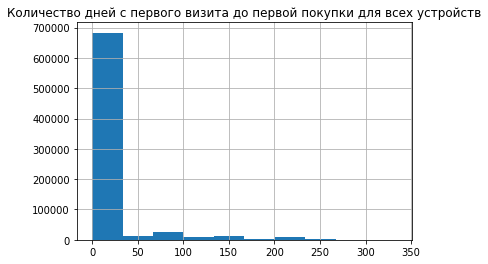

In [72]:
visits.loc[visits['days_before_first_order'].notna(),'days_before_first_order'].hist()
plt.title('Количество дней с первого визита до первой покупки для всех устройств');

Теперь посморим как часто пользователи покупают. Найдем количество покупкой в день/месяц/год

Для этого добавим в таблицу с заказами год/месяц/неделю заказа

In [73]:
orders['year'] = orders['buy_ts'].dt.year
orders['month'] = orders['buy_ts'].dt.month
orders['week'] = orders['buy_ts'].dt.week
orders['day'] = orders['buy_ts'].dt.date

In [74]:
print('Количество заказов по годам')
display(orders.groupby('year')['revenue'].count())

Количество заказов по годам


year
2017    27428
2018    22936
Name: revenue, dtype: int64

In [75]:
# удалим единственный заказ в июне, так как он "заваливает" график
orders['buy_ts'].max()
orders = orders.query('buy_ts != "2018-06-01 00:02:00"')

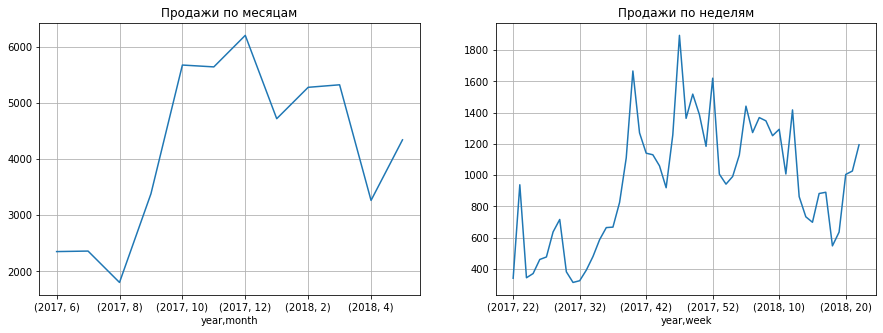

In [76]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
orders.groupby(['year','month'])['revenue'].count().plot(grid=True, ax=axs[0]).set_title('Продажи по месяцам')
orders.groupby(['year','week'])['revenue'].count().plot(grid=True, ax=axs[1]).set_title('Продажи по неделям');

Все говорит о том, что первое полугодие было успешнее последующего, по крайней мере в абсолютных цифрах. Может сказывается тот факт, что после зимы люди больше проводят времени в отпусках, на свежем воздухе и т.п.
Интересно, что увидем по деньгам.

Text(0.5, 1.0, 'Продажи по дням')

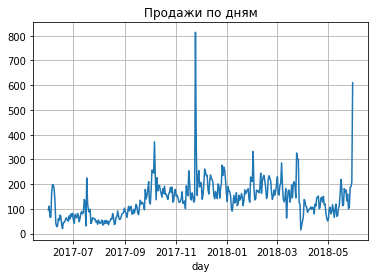

In [77]:
orders.groupby(['day'])['revenue'].count().plot(grid=True).set_title('Продажи по дням')

По дням мы видим что новый год является пиковым значением, а так же на конец первого полугодия приходится много продаж.

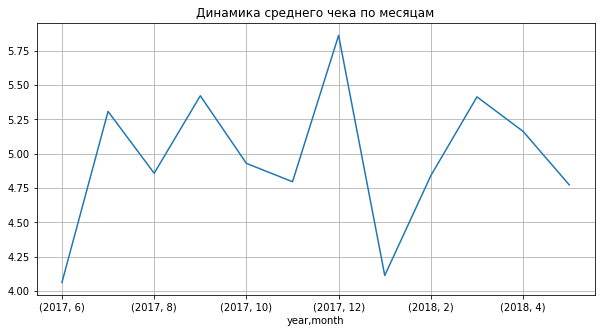

In [78]:
plt.figure(figsize=(10, 5))
orders.groupby(['year','month'])['revenue'].mean().plot(grid=True)
plt.title('Динамика среднего чека по месяцам');

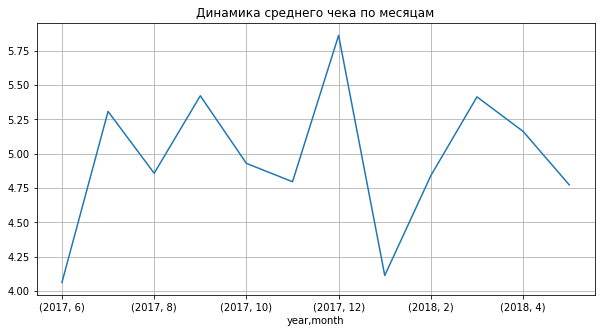

In [79]:
plt.figure(figsize=(10, 5))
orders.groupby(['year','month'])['revenue'].mean().plot(grid=True)
plt.title('Динамика среднего чека по месяцам');

Средний чек колеблится от 4 - 5,75 у.е., пиковые значения были под НГ (что не удивительно). И вроде бы после январского спада пошел подъем, но потом опять падение. 

Далее приступим к анализу LTV. 

In [80]:
# определим месяц покупки 
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [81]:
# посчитаем количество пользователей каждой когорты 
orders_cohort_size = orders.groupby('first_buy_month').agg({'uid':'nunique'}).reset_index()
orders_cohort_size.columns = ['first_buy_month', 'buyers']
orders_cohort_size

,first_buy_month,buyers
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340
5,2017-11-01,4078
6,2017-12-01,4380
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3534


In [82]:
# рассчитаем выручку каждой когорты по месяцам и объединим таблицу с количеством пользователей и выручкой
orders_revenue = orders.groupby(['first_buy_month', 'buy_month'])['revenue'].sum().reset_index()
ltv_report = pd.merge(orders_cohort_size,orders_revenue, on='first_buy_month')

In [83]:
# выделим срок жизни когорт, посчитаем ltv и посмотрим на результат
ltv_report['age'] = ((ltv_report['buy_month'] - ltv_report['first_buy_month']) / np.timedelta64(1,'M')).round().astype('int')
ltv_report['ltv'] = ltv_report['revenue']/ltv_report['buyers']
ltv_report.pivot_table(index='first_buy_month', values='ltv', columns='age', 
                       aggfunc='sum', fill_value='', margins=True)

age,0,1,2,3,4,5,6,7,8,9,10,11,All
first_buy_month,,,,,,,,,,,,,
2017-06-01 00:00:00,4.7,0.49,0.44,0.96,1,0.74,0.95,0.58,0.55,0.61,0.57,0.26,12
2017-07-01 00:00:00,6,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,,8.4
2017-08-01 00:00:00,5.3,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,,8.5
2017-09-01 00:00:00,5.6,1.1,0.52,4,0.4,0.65,0.7,0.24,0.18,,,,13
2017-10-01 00:00:00,5,0.54,0.19,0.16,0.15,0.12,0.085,0.12,,,,,6.4
2017-11-01 00:00:00,5.2,0.4,0.2,0.33,0.15,0.054,0.12,,,,,,6.4
2017-12-01 00:00:00,4.7,0.26,0.93,1.1,0.31,0.34,,,,,,,7.6
2018-01-01 00:00:00,4.1,0.29,0.3,0.14,0.063,,,,,,,,4.9
2018-02-01 00:00:00,4.2,0.28,0.079,0.074,,,,,,,,,4.6


Итого лучше прочих себя показали, естественно, первая, и, неожиданно, когорта 2017-09-01

### Вывод

В среднем пользователи начинают покупать на 13 (десктопы) и 53 (мобильные) день. Однако, чаще всего это происходит в день первого визита. Тем не менее, стоит задуматься, может на мобильных устрйоствах процесс покупки затруднен? 

Пик покупок пришелся на первое полугодие и это связано с активностью на НГ, там было зафиксировано большее всего покупок. В свою очередь, месячный средний чек находится в районе +-5 у.е. с пиковым значением на НГ и падением в январе.

Самой прибыльной когортой оказалась 2017-09-01, и, естественно, самая первая, в силу того что она старше всех.


## Маркетинг

In [84]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [85]:
print('Всего потрачего на продвижение -',costs['costs'].sum())

Всего потрачего на продвижение - 329131.62


Сервис за все время потратил значительные средства на маркетинг. 

In [86]:
print('Выручка всего -',orders['revenue'].sum())

Выручка всего - 252053.78


Уже сейчас можно сказать, что за анализируемый период мы оказались в убытке. Изучим подробнее затраты по источникам.

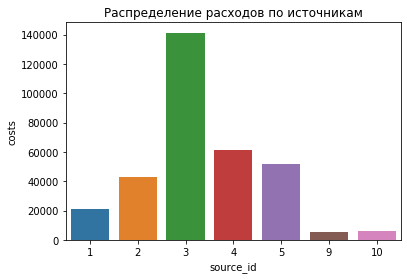

In [87]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
sns.barplot(x="source_id", y="costs", data=costs_by_source)
plt.title('Распределение расходов по источникам');

Итого, на источник № 3 мы потратили значительно больше чем на все остальные.

In [88]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

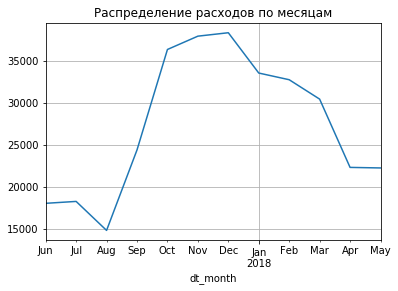

In [89]:
costs_by_months = costs.groupby(['dt_month'])['costs'].sum()
costs_by_months.plot(grid=True, title='Распределение расходов по месяцам');

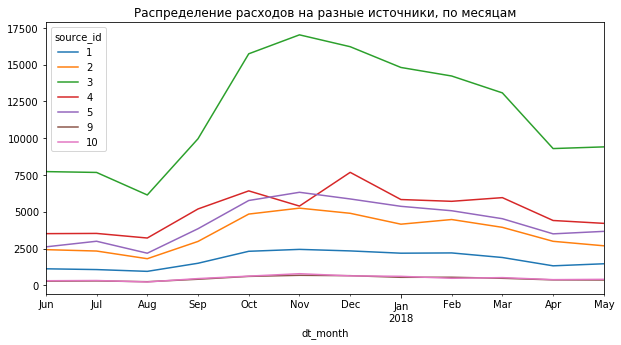

In [90]:
sources_costs_by_month = costs.pivot_table(index='dt_month', columns='source_id', values='costs', aggfunc='sum')
sources_costs_by_month.plot(figsize=(10, 5), title='Распределение расходов на разные источники, по месяцам');

Пик наших расходов (как и доходов) пришлеся на осень/зиму 2017. Примечательно, хоть мы и тратитились в октябре/ноябре/декабре практически одинаково, действительно значимый результат был только в под новый год. 

In [91]:
# определим количество ПЕРВЫХ заходов из каждого источника
original_source = visits.groupby(['uid','source_id','device'])['start_ss'].min().reset_index()
original_source_count = original_source.groupby('source_id')['uid'].count().reset_index().rename(columns={'uid':'n_users'})
original_source_count

,source_id,n_users
0,1,19266
1,2,26866
2,3,76020
3,4,84920
4,5,57428
5,6,6
6,7,34
7,9,9481
8,10,8144


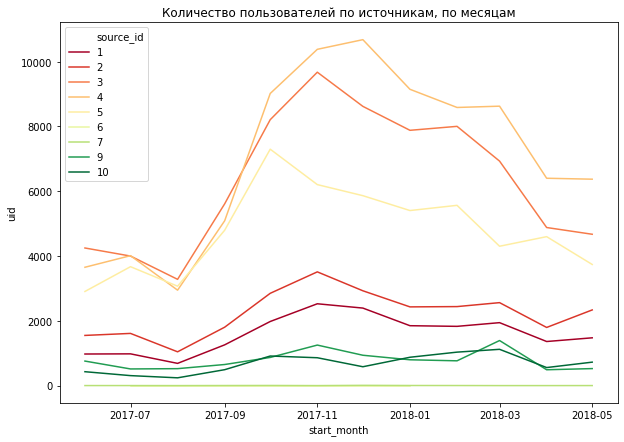

In [92]:
# дополнительно визуализируем количество пользователей из разных истоничков по месяцам
original_source['start_month'] = original_source['start_ss'].astype('datetime64[M]')
original_source_by_month = original_source.groupby(['start_month','source_id'])['uid'].count().reset_index()
plt.figure(figsize=(10, 7))
plt.title('Количество пользователей по источникам, по месяцам')
sns.lineplot(data=original_source_by_month,x='start_month', hue='source_id', y='uid', legend='full', palette='RdYlGn');

In [93]:
acquisition_cost = original_source_count.merge(costs_by_source, on='source_id', how='left').fillna(0)
acquisition_cost['one_user_cost'] = acquisition_cost['costs'] / acquisition_cost ['n_users']

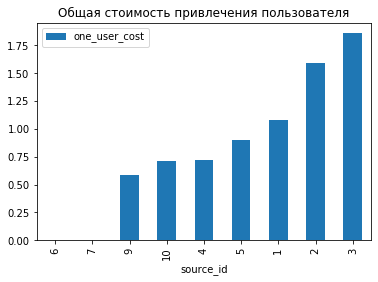

In [94]:
acquisition_cost.sort_values(by='one_user_cost').plot(kind='bar', x='source_id', y='one_user_cost', title='Общая стоимость привлечения пользователя');

In [95]:
# делаю df для расчета cac по месяцам в разрезе источника
costs_by_source_by_month = costs.groupby(['dt_month','source_id'])['costs'].sum().reset_index()
cac_by_month = original_source_by_month.merge(costs_by_source_by_month, left_on=['start_month','source_id']
                                             ,right_on=['dt_month','source_id'])
cac_by_month['cac'] = cac_by_month['costs'] / cac_by_month['uid']
cac_by_month.sample(5)

,start_month,source_id,uid,dt_month,costs,cac
20,2017-08-01,10,241,2017-08-01,232.57,0.97
12,2017-07-01,9,515,2017-07-01,302.54,0.59
13,2017-07-01,10,309,2017-07-01,329.82,1.07
19,2017-08-01,9,524,2017-08-01,248.93,0.48
10,2017-07-01,4,4012,2017-07-01,3529.73,0.88


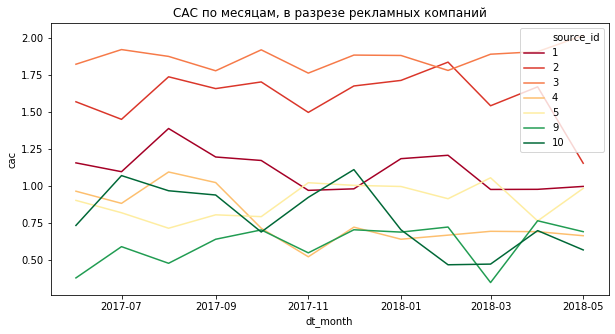

In [96]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=cac_by_month, x='dt_month', y='cac', hue='source_id', legend='full', palette='RdYlGn')
plt.title('CAC по месяцам, в разрезе рекламных компаний');

Дешевле всего обошлись посетители из 6 и 7 источника, там мы не потратили ничего :)

Далее топ-3: 9, 10, 4

Видно, что самые дорогие пользователи из источника - 3 и 2. Может не стоит так много тратить на них, учитывая что из 4го (дешевого), к нам приходит на много больше пользователей чем с 3го. И второй тоже не выглядит сильно перспективным, в то время как с не дорого 5го мы получили больше клиентов. 

Далее посмотрим на вопрос обобщенно, рассчитаем CAC и узнаем как окупаются наши расходы.

In [97]:
romi_report = ltv_report.merge(costs_by_months, left_on='first_buy_month', right_on='dt_month')
romi_report['cac'] = romi_report['costs'] / romi_report['buyers']
romi_report['romi'] = (romi_report['ltv'] /  romi_report['cac']).round(2)

In [98]:
# приводим дату в более читабельный вид
romi_report['first_buy_month'] = romi_report['first_buy_month'].dt.strftime('%Y-%m')

In [99]:
romi = romi_report.pivot_table(index='first_buy_month', columns='age', values='romi', aggfunc='mean').cumsum(axis=1)

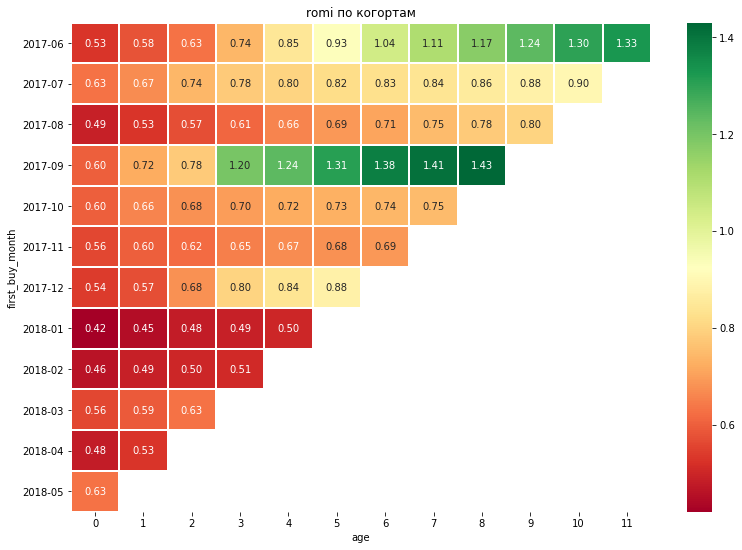

In [100]:
plt.figure(figsize=(13, 9))
plt.title('romi по когортам')
sns.heatmap(romi,annot=True, fmt='.2f', linewidths=1, cmap="RdYlGn");

Как было отмечено ранее, когорта 2017-09-01 одна из лучших для бизнеса, вышла на окупаемость уже на 3 месяц.
Кроме неё окупилась только самая первая когорта, на 6ой месяц жизни. И вторая когорта наиболее близка к тому, чтобы окупиться. Можно отметить, что почти каждая когорта в нулевой месяц жизни окупает свое привлечение +- на половину. Далее, из-за больших потерь пользователей для каждой когорты, окупаемость уже растет не так быстро.

[План работы](#plan)

<a id=plan></a>
# Шаг 3. Выводы

В работе были достаточно качественные датасеты, ошибок и проблем с ними было мало. 

Что мы узнали о продукте и какие рекомендации можно дать. Как оказалось, retention Я.Афиши достаточно скромный (по крайней мере был), уже на первый месяц жизни к нам возвращается около 7% пользователей, и почти для каждой новой когорты этот показатель уменьшается. Что неминуемо скзывается на прибыли, окупилось только 2 когорты, следовательно мы в минусе. Необходимо работать над удержанием пользователей, стимулировать их совершать больше покупок, устаривать акции и т.п.

Как показали графики выше, мы получаем больше всего пользователей из источника 4, в то время как тратим на привлечение не так много денег. Как минимум можно взять большу часть бюджета 2го источника и перенаправить на 4ый. Так как из второго мы получаем малый отклик. Аналогично нужно поступить с 5ым, его пользователи не дорогие, но оттуда мы имеем хороший поток посетителей, сопоставымий с 3им, который несмотря на свою дороговизну не оправдывает ожиданий.

Нелишним будет дополнительно изучить среднее время покупки на мобильных устройствах, почему-то оно значительно выше чем у десктопов. Возможно есть сложности с оплатой в приложени.